# Driver Identification using ResNet50 and GRU (RNN)
To better understand the code, check out `./prep_files/ResNet50_GRU_driverID.ipynb`. That notebook explains the thought process behind this code on a sample dataset whilst this goes straight to the point. 

Also the dataset used was different as that stored all data in memory while we plan on streaming from local storage as the dataset is 40+Gb

In [1]:
import numpy as np
import pandas as pd
import torch
from torchsummary import summary

from src.engine import ResNet50_GRU_engine
from src.model_driverID import ResNet50_GRU
from src.dataset import FeatureMapDataset
from src.hyperparam import RayTuning
from ray import tune, train

from IPython.display import display, HTML

# Load custom CSS file
css = HTML('<link rel="stylesheet" type="text/css" href="./custom.css">')  # Ensure the path is correct
display(css)

In [2]:
model = ResNet50_GRU()
summary(model, verbose=0)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       (9,408)
|    └─BatchNorm2d: 2-2                  (128)
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─Sequential: 2-5                   --
|    |    └─Bottleneck: 3-1              (75,008)
|    |    └─Bottleneck: 3-2              (70,400)
|    |    └─Bottleneck: 3-3              (70,400)
|    └─Sequential: 2-6                   --
|    |    └─Bottleneck: 3-4              (379,392)
|    |    └─Bottleneck: 3-5              (280,064)
|    |    └─Bottleneck: 3-6              (280,064)
|    |    └─Bottleneck: 3-7              (280,064)
|    └─Sequential: 2-7                   --
|    |    └─Bottleneck: 3-8              (1,512,448)
|    |    └─Bottleneck: 3-9              (1,117,184)
|    |    └─Bottleneck: 3-10             (1,117,184)
|    |    └─Bottleneck: 3-11             (1,117,184)
|    |    └─Bottleneck: 3

In [3]:
from sklearn.utils.class_weight import compute_class_weight

import torch.nn as nn
import torch.optim as optim

#### Hyperparameter tuning of Model

In [4]:
y_train = pd.read_csv('./data/feature_maps_labels/train/metadata.csv')
y_train = y_train.iloc[:,1].values

class_weights = torch.tensor(compute_class_weight('balanced', classes=np.unique(y_train), y=y_train), dtype=torch.float32)
class_weights = class_weights.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

del y_train

In [5]:
base_dir = './data/feature_maps_labels/'

train_datasets = FeatureMapDataset(base_dir, mode='train')
val_test_datasets = FeatureMapDataset(base_dir, mode='valid')

In [6]:
from torch.utils.data import random_split

In [7]:
np.random.seed(42)
valid_datasets, test_datasets = random_split(val_test_datasets, [0.5, 0.5])

In [8]:
len(train_datasets), len(valid_datasets), len(test_datasets)

(46240, 5782, 5781)

In [9]:
# Enhanced Hyperparameter search space
config = {
    "optimizer": tune.choice(["adam"]),
    "lr": tune.loguniform(1e-4, 1e-1),
    "scheduler": tune.choice(["exp"]),
    "gamma": tune.uniform(0.1, 0.9),
    "epochs": tune.choice([30]),
    "batch_size": tune.choice([32])
}

criterion = nn.CrossEntropyLoss(weight=class_weights)
save_dir = 'ResNet50GRU'
model = ResNet50_GRU
modelType = 'ResNet50GRU'
engine = ResNet50_GRU_engine

In [10]:
mytuner = RayTuning(config, save_dir, criterion, model, modelType, engine)

In [11]:
mytuner.main(train_datasets, valid_datasets, test_datasets, num_samples=25)

(train_model pid=26652) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/ResNet50GRU/trial_aca60_00000/checkpoint_000000)
(train_model pid=26652) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/ResNet50GRU/trial_aca60_00000/checkpoint_000001)
(train_model pid=26652) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/ResNet50GRU/trial_aca60_00000/checkpoint_000002)
(train_model pid=26652) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Pr

Best trial config: {'optimizer': 'adam', 'lr': 0.0003872118032174588, 'scheduler': 'exp', 'gamma': 0.13618183112843046, 'epochs': 30, 'batch_size': 32}
Best trial final validation loss: 1.2275166817791554
Best trial final validation accuracy: 66.0325%
Test Accuracy: 0.6652828230409964
Best trial test set accuracy: 0.6653%


#### Model Training with given hyperparameters

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from src.engine import ResNet50_GRU_engine
from src.model_driverID import ResNet50_GRU
from src.dataset import FeatureMapDataset

In [18]:
np.random.seed(42)

batch_size = 64
train_dl = DataLoader(train_datasets, batch_size, shuffle=True, num_workers=4)
valid_dl = DataLoader(valid_datasets, batch_size, shuffle=True, num_workers=4)
test_dl = DataLoader(test_datasets, batch_size, shuffle=False, num_workers=2)

In [19]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
model = ResNet50_GRU()
optimizer = optim.Adam(model.parameters(), lr=0.0003872118032174588)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.13618183112843046)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

In [20]:
engine = ResNet50_GRU_engine(model, optimizer, scheduler, criterion, device)

In [21]:
hist = engine.train_validation(train_dl, valid_dl, epochs=80, save_path='./model_checkpoint/run1_ResNet50_GRU_chkpt.pth')

np.save('./model_checkpoint/run1_ResNet50_GRU_history.npy', np.array(hist))

   Epoch [1/80], Train Loss: 1.2678, Train Accuracy: 57.42%, Val Loss: 1.2282, Val Accuracy: 61.29%
   Epoch [2/80], Train Loss: 1.1479, Train Accuracy: 62.15%, Val Loss: 1.2411, Val Accuracy: 61.36%
   Epoch [3/80], Train Loss: 1.1180, Train Accuracy: 63.18%, Val Loss: 1.2393, Val Accuracy: 63.80%
   Epoch [4/80], Train Loss: 1.1100, Train Accuracy: 63.23%, Val Loss: 1.2486, Val Accuracy: 62.14%
   Epoch [5/80], Train Loss: 1.1102, Train Accuracy: 63.01%, Val Loss: 1.2521, Val Accuracy: 63.59%
   Epoch [6/80], Train Loss: 1.1133, Train Accuracy: 63.11%, Val Loss: 1.2504, Val Accuracy: 63.71%
   Epoch [7/80], Train Loss: 1.1133, Train Accuracy: 63.41%, Val Loss: 1.2387, Val Accuracy: 61.90%
   Epoch [8/80], Train Loss: 1.1061, Train Accuracy: 63.30%, Val Loss: 1.2612, Val Accuracy: 64.56%
   Epoch [9/80], Train Loss: 1.1130, Train Accuracy: 63.25%, Val Loss: 1.2463, Val Accuracy: 62.95%
   Epoch [10/80], Train Loss: 1.1198, Train Accuracy: 62.92%, Val Loss: 1.2456, Val Accuracy: 63.59%

Plotting history

In [22]:
from src.plot import plot_history

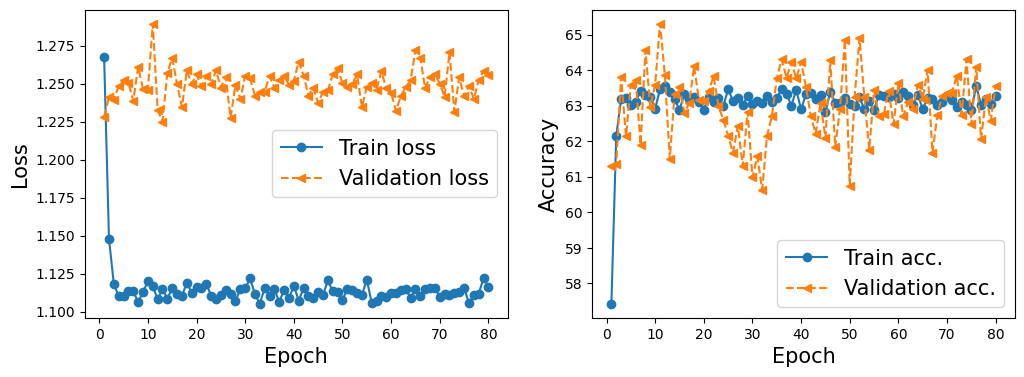

In [23]:
plot_history(hist)

## 2nd Run with Hyperparam Optimization and Model training.
Decided to rescale my images to [0, 1] and normalize it to the mean and std of ImageNet data used in training the pretrained ResNet50 model. This was done in accordance to the advice on the documentation. Hopefully, we would observe an improved performance.

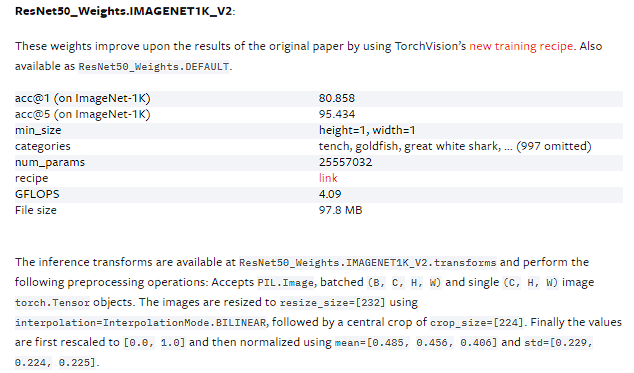

In [9]:
# Enhanced Hyperparameter search space
config = {
    "optimizer": tune.choice(["adam"]),
    "lr": tune.loguniform(1e-5, 1e-3),
    "scheduler": tune.choice(["exp"]),
    "gamma": tune.uniform(0.1, 0.9),
    "epochs": tune.choice([30]),
    "batch_size": tune.choice([64])
}

criterion = nn.CrossEntropyLoss(weight=class_weights)
save_dir = 'ResNet50GRU'
model = ResNet50_GRU
modelType = 'ResNet50GRU'
engine = ResNet50_GRU_engine

In [10]:
mytuner = RayTuning(config, save_dir, criterion, model, modelType, engine)

In [11]:
mytuner.main(train_datasets, valid_datasets, test_datasets, num_samples=30)

(train_model pid=1876) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/ResNet50GRU/trial_91898_00000/checkpoint_000000)
(train_model pid=1876) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/ResNet50GRU/trial_91898_00000/checkpoint_000001)
(train_model pid=1876) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Project (2023)/workspace/ray_results/ResNet50GRU/trial_91898_00000/checkpoint_000002)
(train_model pid=1876) Checkpoint successfully created at: Checkpoint(filesystem=local, path=c:/Users/LEGION/Documents/Msc Data Science - Uni of Exeter/ECMM451 - Data Science Research Projec